In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [12]:
df = pd.read_csv('./data/final_0509.csv')

In [13]:
cols = list(df.columns)
cols.remove('Date')

In [14]:
df[cols] = df[cols].astype(int)

In [15]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [16]:
df.Date = pd.to_datetime(df.Date)
#df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [17]:
lag_col= list(df.columns)

In [18]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

In [21]:
df.isnull().sum().sum()

0

In [22]:
df.rename(columns={'TARGET':'target'},inplace=True)

In [23]:
plt.style.use('ggplot')

In [24]:
#df.plot(subplots=True, figsize=(10,20))

## lag 변수 생성

In [25]:
lag_amount = 3

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['target'].shift(i+1)
    
df.dropna(inplace=True)

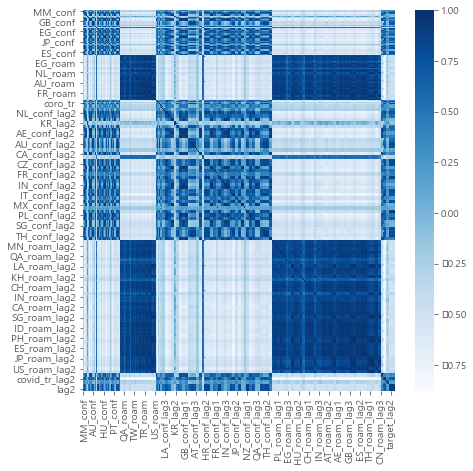

In [26]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(), cmap='Blues')

# X_변수 정의

In [27]:
X_cols = list(df.columns)
X_cols.remove('target')

In [29]:
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

In [30]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

### 2-1. 모델생성

#### 2-1-1) 기본 옵션으로 모델 생성

In [33]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf_uncustomized.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(rf_uncustomized.score(X_test,y_test)))

Score on training set : 0.973
Score on test set : -0.581


#### 2-1-2) 현재 생성된 트리 모델의 옵션 확인

In [34]:
rf_uncustomized

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### 2-2. 모델 Parameter 조정

#### 2-2-1) n_estimator : 트리 수 변경에 따른 모델 성능

In [35]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,40)]

for v_n_estimators in para_n_tree :
    rf = RandomForestRegressor(n_estimators= v_n_estimators)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test,y_test))

# 결과 저장

df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score
df_score_n['Gap'] = df_score_n['TrainScore'] - df_score_n['TestScore']

In [36]:
# 모델 설명력 확인
df_score_n.round(3).sort_values(by='Gap').head()

,n_estimators,TrainScore,TestScore,Gap
6,70,0.975,-0.462,1.437
22,230,0.973,-0.466,1.439
15,160,0.974,-0.500,1.475
3,40,0.967,-0.531,1.499
13,140,0.973,-0.546,1.518


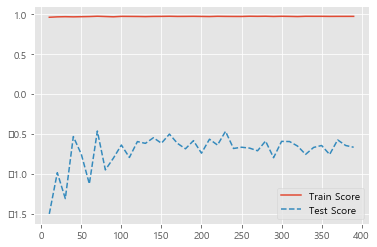

In [37]:
# 모델 설명력 그래프 확인

plt.plot(para_n_tree, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

#### 2-2-2) min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [39]:
train_score = []; test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf :
    rf = RandomForestRegressor(n_estimators=70,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test,y_test))
    
# 결과 저장

df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score
df_score_leaf['Gap'] = df_score_leaf['TrainScore'] - df_score_leaf['TestScore']

In [40]:
# 모델 설명력 확인
df_score_leaf.round(3).sort_values(by='Gap').head()

,MinSamplesLeaf,TrainScore,TestScore,Gap
2,3,0.961,-0.678,1.639
14,15,0.808,-0.841,1.649
3,4,0.950,-0.733,1.683
15,16,0.796,-0.906,1.702
7,8,0.896,-0.808,1.704


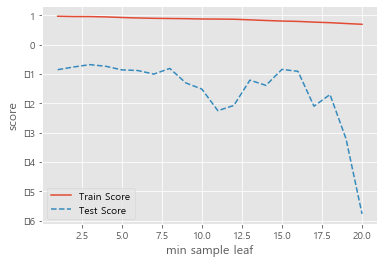

In [41]:
# 모델 설명력 그래프 확인

plt.plot(para_leaf, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score'); plt.xlabel("min sample leaf")
plt.legend()

#### 2-2-3) min_samples_split : 분리노드의 최소 자료 수 변경에 따른 모델 성능

In [42]:
train_score = []; test_score = []

para_split = [n_split * 2 for n_split in range(2,41)]

for v_min_samples_split in para_split :
    rf = RandomForestRegressor(n_estimators=70,
                                 min_samples_leaf = 3,
                                min_samples_split = v_min_samples_split)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    test_score.append(rf.score(X_test, y_test))
    
# 결과 저장

df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
df_score_split['Gap'] = df_score_split['TrainScore'] - df_score_split['TestScore']

In [43]:
# 모델 설명력 확인
df_score_split.round(3).sort_values(by='Gap').head()

,MinSamplesSplit,TrainScore,TestScore,Gap
25,54,0.663,-0.253,0.916
24,52,0.765,-0.343,1.108
23,50,0.841,-0.442,1.283
18,40,0.881,-0.537,1.417
16,36,0.897,-0.525,1.422


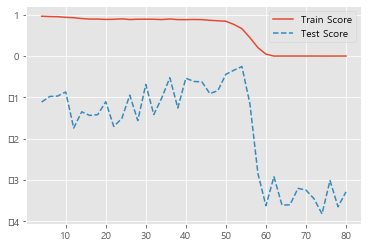

In [44]:
# 모델 설명력 그래프 확인

plt.plot(para_split, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

# GridSearch

In [233]:
param_grid = { 
    'n_estimators': [30, 110, 140],
    'min_samples_leaf' : [4, 18, 3],
    'min_samples_split' : [8, 4, 6],
}

In [234]:
# grid search
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [235]:
CV_rfc

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=4,
                                             min_samples_split=80,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=140, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [236]:
CV_rfc.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=4,
                                             min_samples_split=80,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=140, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [237]:
CV_rfc.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 140}

## Feature Selection 1

In [45]:
X_cols = list(df.columns)
X_cols.remove('target')

In [46]:
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']


In [47]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [48]:
# parameter 설정
rf = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, min_samples_split=54, max_features='auto')
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=54, min_weight_fraction_leaf=0.0,
                      n_estimators=70, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [49]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = list(X.columns)
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(20)

,Feature,Importance
117,AU_conf_lag3,0.308
175,NZ_conf_lag1,0.138
176,NZ_conf_lag2,0.121
198,TH_conf_lag3,0.072
31,NZ_conf,0.055
119,AT_conf_lag2,0.040
323,covid_tr_lag2,0.034
195,CH_conf_lag3,0.029
145,DE_conf_lag1,0.029
328,target_lag1,0.027


In [50]:
new_importance = df_importance[df_importance['Importance'] > 0.01]

In [51]:
#df_importance.to_csv('feature_importance.csv')

Text(0, 0.5, '변수')

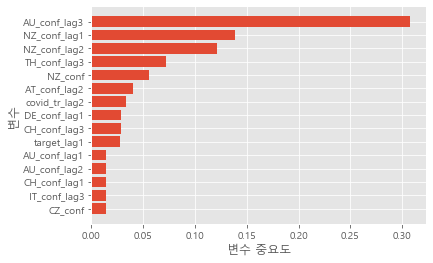

In [52]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(15)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# Feature Selection 2

# Prediction

In [53]:
new_x_cols = list(new_importance['Feature'])

In [54]:
X_cols = list(df.columns)
X_cols.remove('target')

# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분
X = df[X_cols]
y = df['target']

In [55]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [56]:
X_train.shape

(85, 334)

In [57]:
from sklearn.ensemble.forest import RandomForestRegressor

In [58]:
param_grid = { 
    'n_estimators': [110, 130, 370],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf' : [17, 4, 2],
    'min_samples_split' : [8, 4, 6],
}

In [59]:
# build our RF model
RF_Model = RandomForestRegressor(n_estimators=60, min_samples_leaf=3, min_samples_split=6, max_features='auto')

# let's get the labels and features in order to run our 
# model fitting
labels = y_train
features = X_train

# Fit the RF model with features and labels.
rgr=RF_Model.fit(features, labels)

In [60]:
# Now that we've run our models and fit it, let's create
# dataframes to look at the results
X_test_predict=pd.DataFrame(
    rgr.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    rgr.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
RF_predict = X_train_predict.append(X_test_predict)

In [61]:
rgr.predict(X_test)

array([10.66587963,  8.6142791 ,  8.64880952,  8.07451118,  9.92912037,
       11.77880291,  7.24624339,  7.2435588 ,  7.65664683,  7.57340669,
        7.893076  ,  7.48488095,  8.11992785,  7.95144901])

In [62]:
RF_predict.set_index(pd.to_datetime(df.index, format='%Y%m%d'), inplace=True)

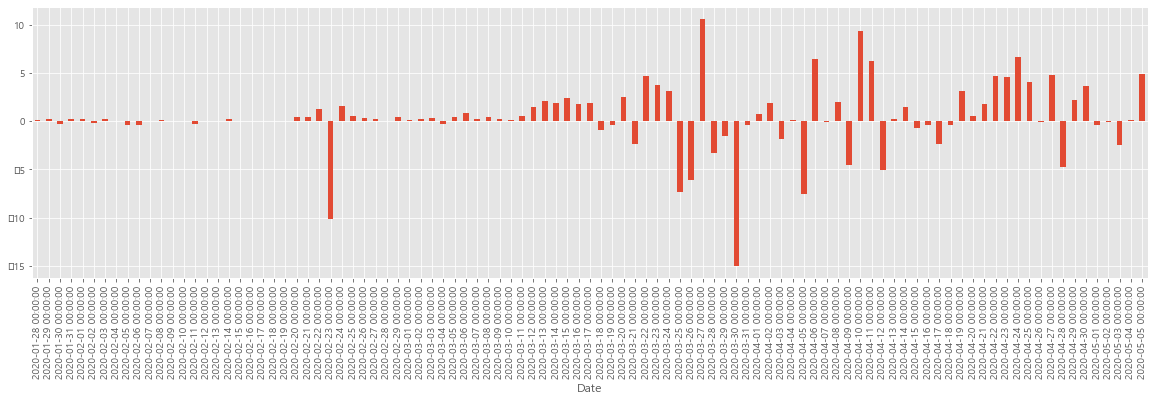

In [63]:
plt.figure(figsize=(20,5))
RF_predict['diff']=RF_predict.predict - df.target
RF_predict['diff'].plot(kind='bar')

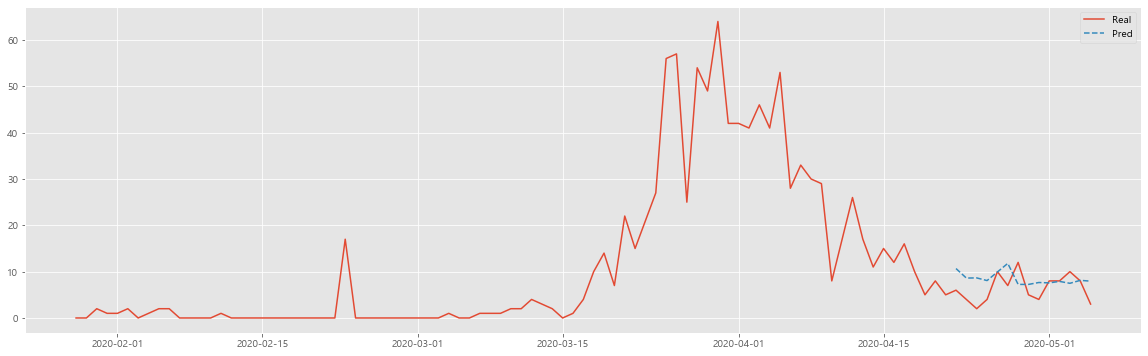

In [64]:
plt.figure(figsize=(20,6))
plt.plot(df['target'], label='Real')
plt.plot(RF_predict['predict'][-len(X_test):], '--',label='Pred', )
plt.legend()

In [65]:
rgr.predict(X_test)

array([10.66587963,  8.6142791 ,  8.64880952,  8.07451118,  9.92912037,
       11.77880291,  7.24624339,  7.2435588 ,  7.65664683,  7.57340669,
        7.893076  ,  7.48488095,  8.11992785,  7.95144901])

In [66]:
from sklearn.metrics import r2_score
RSquared = r2_score(y_train, X_train_predict.values)

In [67]:
RSquared

0.9619800892323856

In [68]:
rgr.predict(X_test)

array([10.66587963,  8.6142791 ,  8.64880952,  8.07451118,  9.92912037,
       11.77880291,  7.24624339,  7.2435588 ,  7.65664683,  7.57340669,
        7.893076  ,  7.48488095,  8.11992785,  7.95144901])

In [69]:
preds = pd.DataFrame({'real':y_test,'pred':rgr.predict(X_test)})

In [70]:
preds['gap'] = preds.real - preds.pred

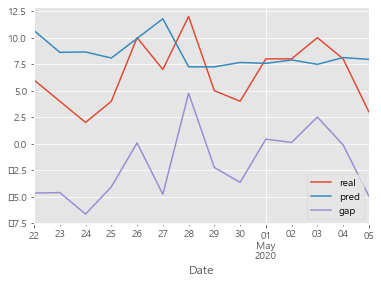

In [71]:
preds.plot()

In [72]:
from sklearn.metrics import mean_squared_error
# validation score
MSE = mean_squared_error(y_test, rgr.predict(X_test))
RMSE = np.sqrt(MSE)
score = 100*(1-(((rgr.predict(X_test) - y_test)**2).sum())/(rgr.predict(X_test)**2).sum())

In [73]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 14.197541962399574, RMSE : 3.7679625744425294, SCORE : 80.77209161019147
